In [1]:
import pandas as pd
import sys
sys.path.append("/Users/danieleraimondi/bitcoin_datascience/functions")

from functions_ThermoModel import (
    load_btc_data,
    cubic_regression,
    logarithmic_regression,
    optimize_params,
    create_cubiclog,
    weight_plot,
    final_plot, 
    inference
)

import warnings
warnings.filterwarnings("ignore")


df, last_date = load_btc_data(train_frac = 0.95, last_date = True)

# Cubic Regression

In [2]:
df, cubic_model_params = cubic_regression(
    df,
    upper=1.05,
    lower=-1.05,
    visualize_plot=False,
)

cubic_model_params

{'degrees': 3,
 'coef': [0.0,
  0.004469426297441029,
  -6.032968164140229e-07,
  2.8110566546891513e-11],
 'intercept': -0.06915047150741316}

# Logarithmic Regression

In [3]:
df, log_model_params = logarithmic_regression(
    df,
    upper=2,
    lower=-2,
    visualize_plot=False,
)

log_model_params

{'coef': 2.877555822905639, 'intercept': -14.722577868540496}

# ENSEMBLE

In [4]:
# Dates for optimization
tops_dates = pd.to_datetime(["2011-06-08","2013-11-30", "2017-12-17", "2021-04-14"])
bottoms_dates = pd.to_datetime(["2012-06-04","2013-01-07","2016-08-02", "2018-12-15", "2022-12-31"])

initial_guess = [0.7, 0.72, -0.3, -0.05]
bounds = [(-1, 1), (-1, 1), (-1, 1), (-1, 1)]

# Run optimization
optimized_params = optimize_params(df, tops_dates, bottoms_dates, initial_guess, bounds)
optimized_params

array([ 0.58531327,  0.81859964,  1.        , -0.49574577])

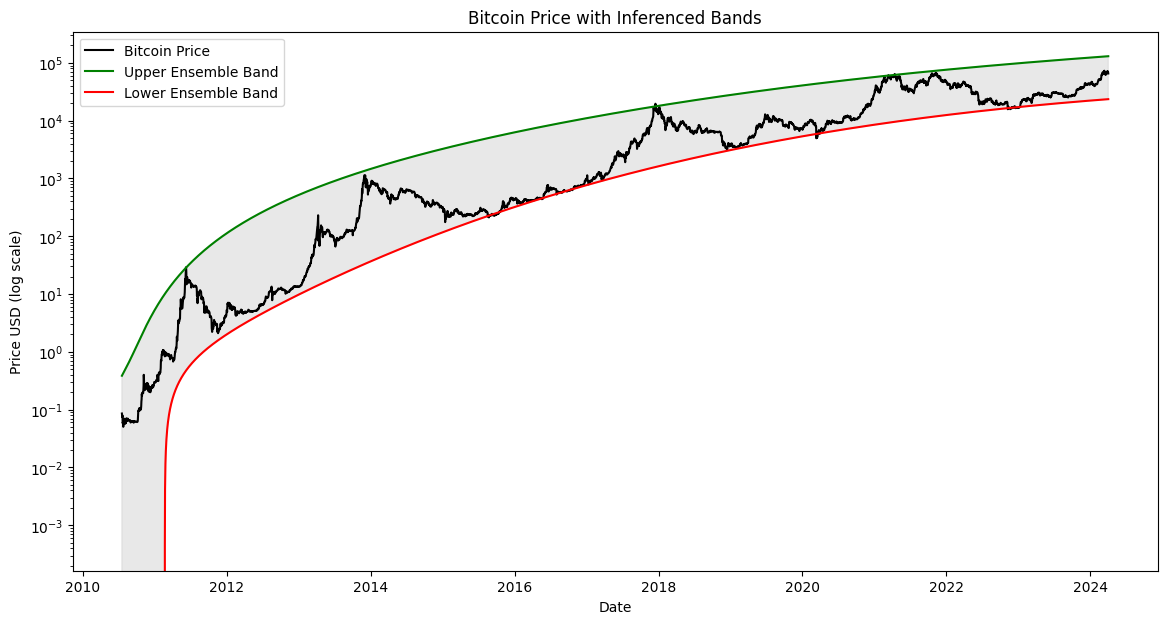

In [5]:
# Load the full dataset
df = load_btc_data(train_frac=1.0, last_date = False)
inference(df, cubic_model_params, log_model_params, optimized_params)

# create_cubiclog(df, optimized_params)

In [6]:
df

,time,PriceUSD,upper_cubic,lower_cubic,upper_log,lower_log,weights_upper,weights_lower,upper_cubiclog,lower_cubiclog,medium_cubiclog,sell_cubiclog,buy_cubiclog,75_cubiclog,25_cubiclog,Oscillator_cubiclog,lowess
0,2010-07-18,0.085840,1.548024,-0.655162,-0.999997,-1.000000,0.455904,-0.182375,0.386372,-0.592273,NaN,NaN,NaN,NaN,NaN,0.752405,NaN
1,2010-07-19,0.080800,1.559434,-0.653618,-0.999978,-1.000000,0.455957,-0.182411,0.392452,-0.590435,NaN,NaN,NaN,NaN,NaN,0.752405,NaN
2,2010-07-20,0.074736,1.570891,-0.652068,-0.999930,-0.999999,0.456010,-0.182448,0.398570,-0.588589,NaN,NaN,NaN,NaN,NaN,0.752405,NaN
3,2010-07-21,0.079193,1.582396,-0.650511,-0.999839,-0.999997,0.456064,-0.182484,0.404732,-0.586735,NaN,NaN,NaN,NaN,NaN,0.752405,NaN
4,2010-07-22,0.058470,1.593949,-0.648947,-0.999694,-0.999994,0.456117,-0.182520,0.410945,-0.584874,NaN,NaN,NaN,NaN,NaN,0.752405,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5003,2024-03-29,69917.043007,121972.309085,16506.292332,131717.469695,2411.507926,0.818217,-0.495350,129945.964727,23488.142139,55246.622429,109514.439450,27870.199630,84729.426113,36022.777798,0.637670,0.652838
5004,2024-03-30,69663.011907,122038.572929,16515.260168,131793.228760,2412.895502,0.818313,-0.495449,130020.930797,23502.260163,55279.161916,109577.883211,27886.884220,84778.818617,36044.212364,0.635200,0.653016
5005,2024-03-31,71227.451794,122104.828515,16524.226887,131869.016251,2414.283598,0.818408,-0.495548,130095.920556,23516.378036,55311.706255,109641.344864,27903.569156,84828.222560,36065.648395,0.647841,0.652484
5006,2024-04-01,69791.627731,122171.075814,16533.192484,131944.832171,2415.672215,0.818504,-0.495647,130170.934015,23530.495754,55344.255439,109704.824415,27920.254432,84877.637943,36087.085884,0.635594,0.652129


In [7]:
#weight_plot(df)

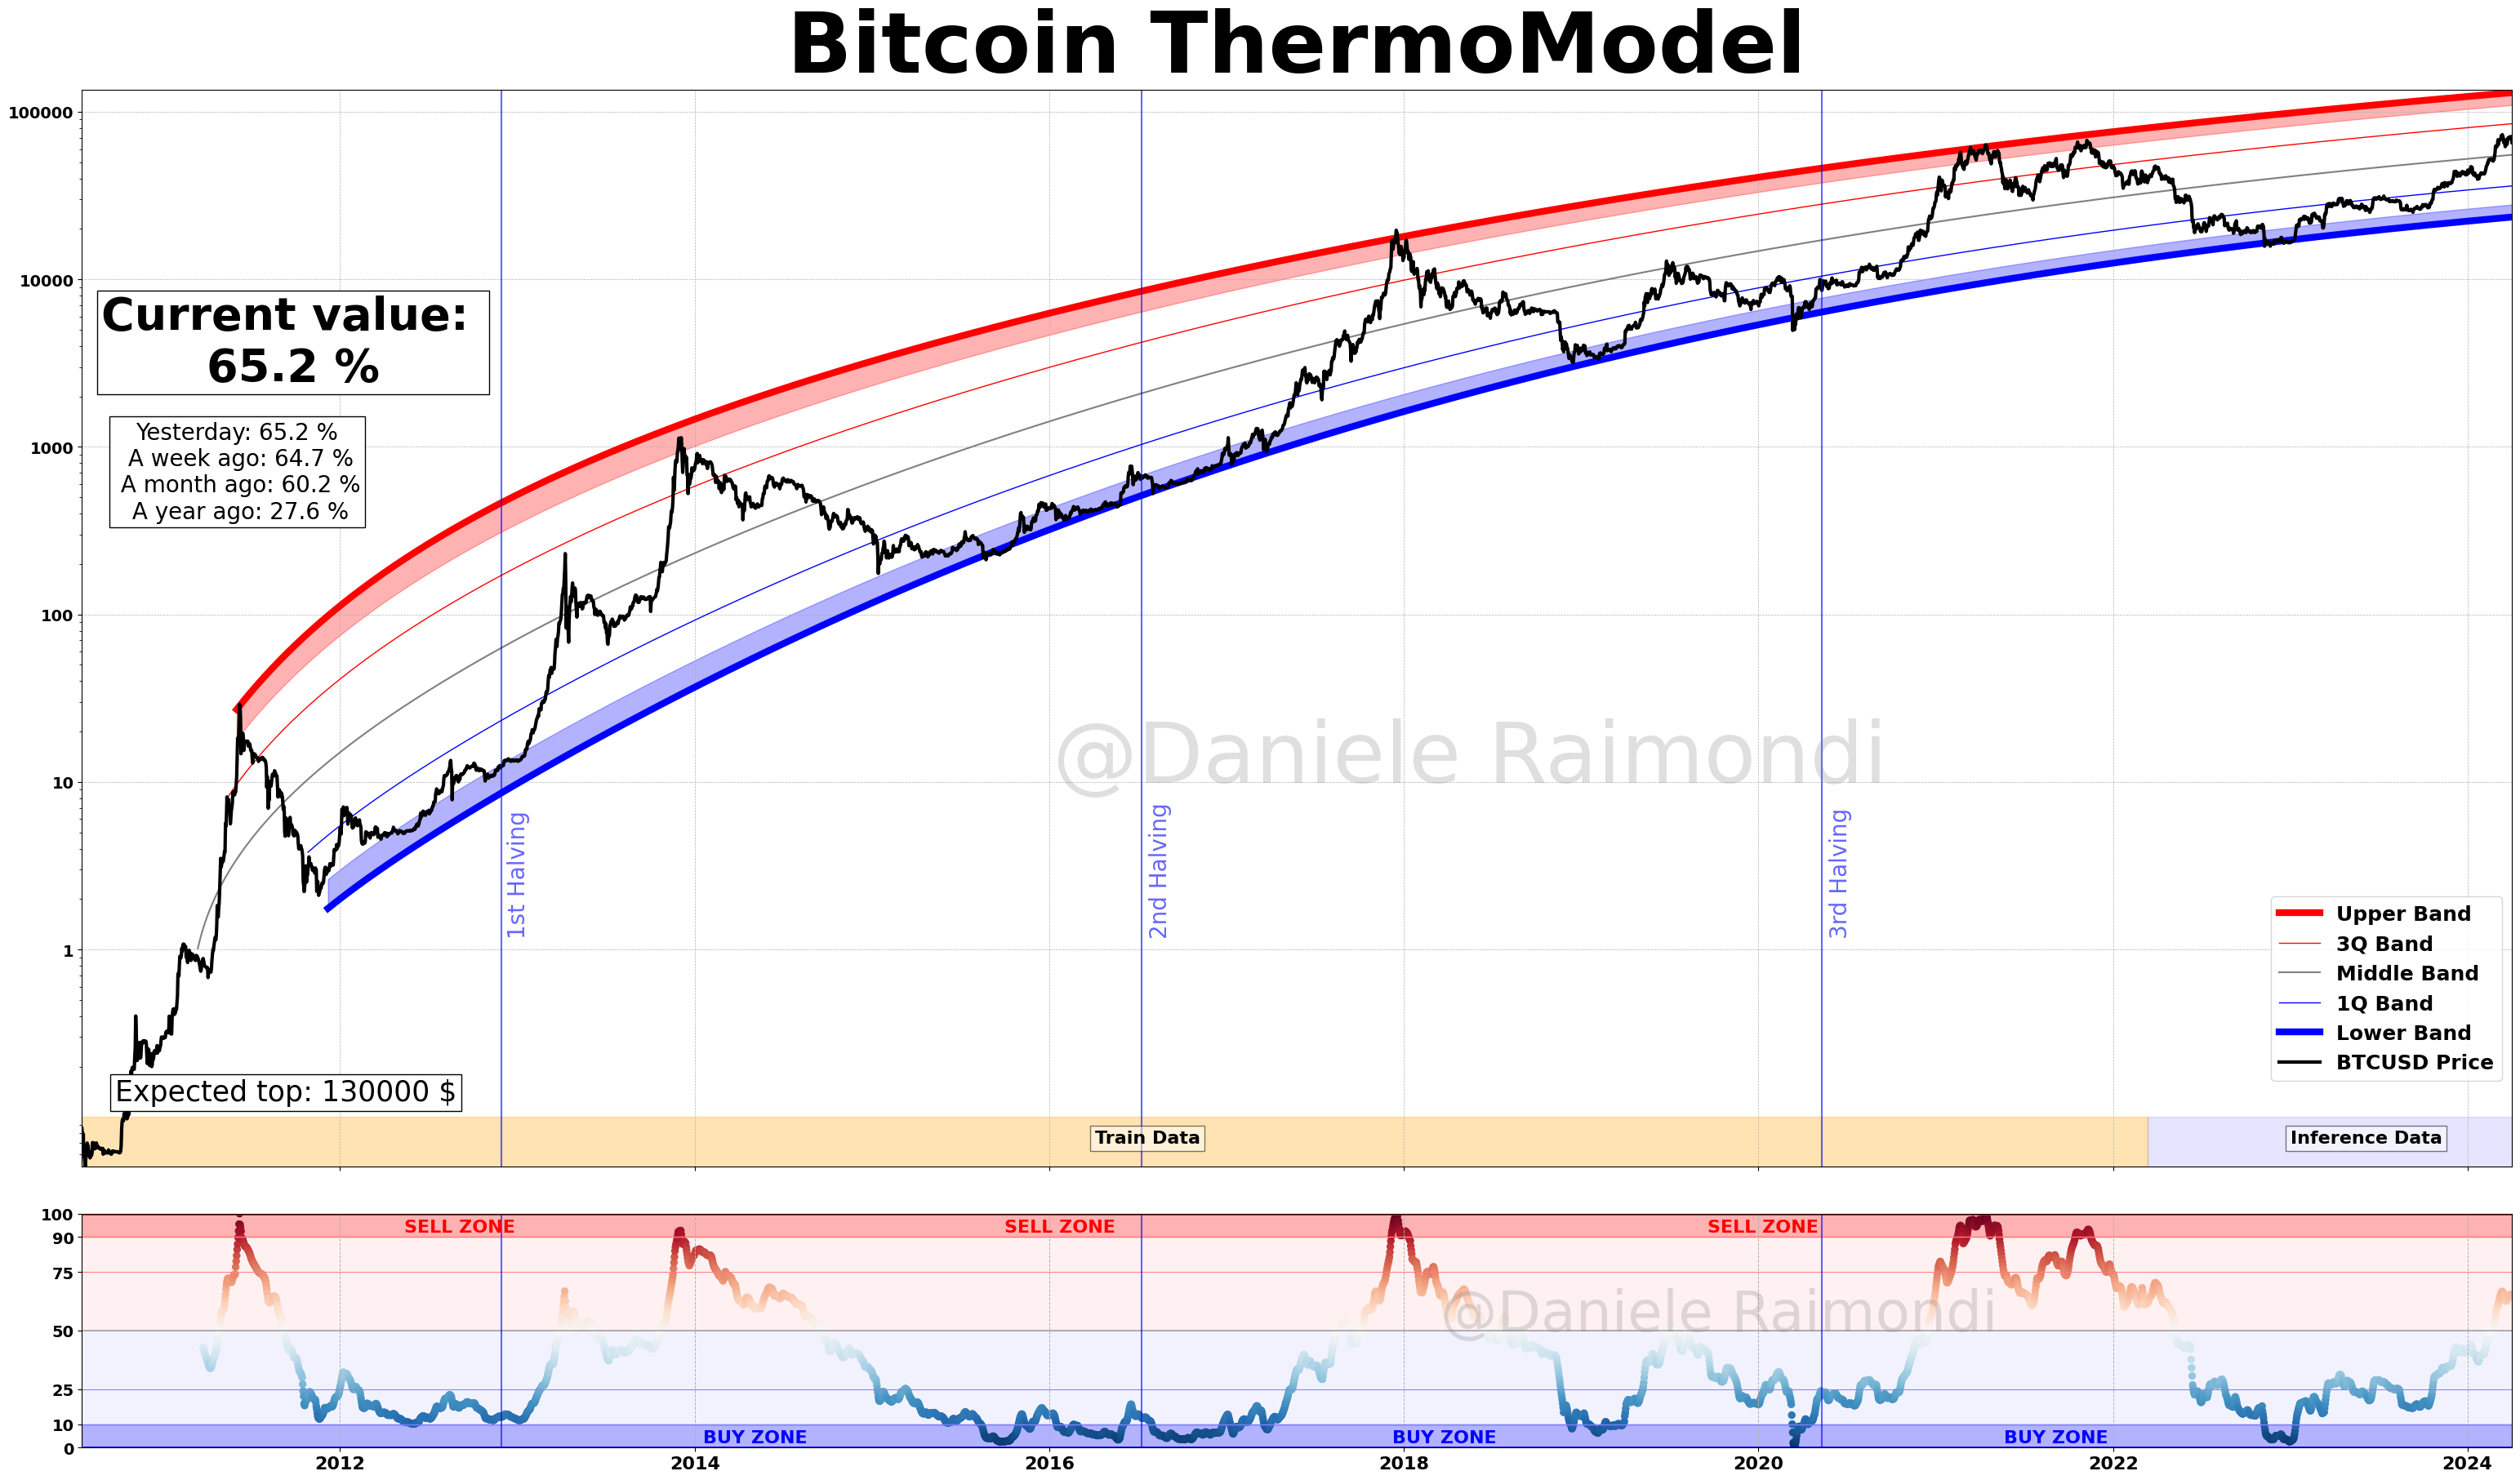

In [8]:
final_plot(df, last_date)